In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/OCT_dataset/dataset_splits (normal).zip" -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset_splits (normal)/val/masks/Farsiu_Ophthalmology_2013_Control_Subject_1018_slice_085_vis.png  
  inflating: /content/__MACOSX/dataset_splits (normal)/val/masks/._Farsiu_Ophthalmology_2013_Control_Subject_1018_slice_085_vis.png  
  inflating: /content/dataset_splits (normal)/val/masks/Farsiu_Ophthalmology_2013_Control_Subject_1036_slice_055_vis.png  
  inflating: /content/__MACOSX/dataset_splits (normal)/val/masks/._Farsiu_Ophthalmology_2013_Control_Subject_1036_slice_055_vis.png  
  inflating: /content/dataset_splits (normal)/val/masks/Farsiu_Ophthalmology_2013_Control_Subject_1013_slice_036.png  
  inflating: /content/__MACOSX/dataset_splits (normal)/val/masks/._Farsiu_Ophthalmology_2013_Control_Subject_1013_slice_036.png  
  inflating: /content/dataset_splits (normal)/val/masks/Farsiu_Ophthalmology_2013_Control_Subject_1090_slice_059_vis.png  
  inflating: /content/__MACOSX/dataset_splits (normal)/val/mask

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
import numpy as np
from tqdm import tqdm

# -------------------
# CONFIG
# -------------------
DATA_DIR = "/content/dataset_splits (normal)"
NUM_CLASSES = 4        # background + 3 retinal layers
BATCH_SIZE = 8
EPOCHS = 20
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEST_MODEL_PATH = "resnet_seg_best.pth"

print("Using device:", DEVICE)

# -------------------
# DATASET
# -------------------
class OCTDataset(Dataset):
    def __init__(self, root_dir):
        self.img_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        # All images
        self.img_files = sorted([f for f in os.listdir(self.img_dir) if f.endswith(".png")])
        # Masks excluding vis.png
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if f.endswith(".png") and "vis" not in f])
        # Only keep matching files
        self.files = [f for f in self.img_files if f in self.mask_files]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        # Load image (grayscale) and convert to 3 channels
        img = np.array(Image.open(os.path.join(self.img_dir, img_name)).convert("L"))
        img = np.stack([img, img, img], axis=0)
        img = torch.tensor(img, dtype=torch.float32) / 255.0

        # Load mask
        mask = np.array(Image.open(os.path.join(self.mask_dir, img_name)).convert("L"))
        mask = torch.tensor(mask, dtype=torch.long)

        return img, mask

# Datasets and loaders
train_ds = OCTDataset(os.path.join(DATA_DIR, "train"))
val_ds   = OCTDataset(os.path.join(DATA_DIR, "val"))
test_ds  = OCTDataset(os.path.join(DATA_DIR, "test"))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# -------------------
# MODEL
# -------------------
class ShallowCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x128 -> 64x64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64 -> 32x32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv3
            nn.ReLU(),
            nn.MaxPool2d(2)   # 32x32 -> 16x16
        )

        # Decoder (upsampling back to original size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 16 -> 32
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),   # 32 -> 64
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),   # 64 -> 128
            nn.ReLU(),

            nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2),   # 128 -> 256
            nn.ReLU(),

            nn.Conv2d(16, num_classes, kernel_size=1)  # final logits
        )

    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      # Ensure output matches target mask size
      x = nn.functional.interpolate(x, size=(256, 256), mode="bilinear", align_corners=False)
      return x


model = ShallowCNN(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# -------------------
# DICE SCORE
# -------------------
def dice_score(pred, target, num_classes=4, smooth=1e-6):
    pred = torch.argmax(pred, dim=1)  # (B,H,W)
    dice = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice.append(((2*intersection + smooth) / (union + smooth)).cpu().item())
    return dice

# -------------------
# TRAIN / EVAL FUNCTIONS
# -------------------
def train_one_epoch(loader, model, optimizer, criterion):
    model.train()
    running_loss = 0
    for imgs, masks in tqdm(loader):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(loader, model, criterion):
    model.eval()
    running_loss = 0
    dice_sum = np.zeros(NUM_CLASSES)
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            dice = dice_score(outputs, masks)
            dice_sum += np.array(dice)
    avg_dice = dice_sum / len(loader)
    return running_loss / len(loader), avg_dice

# -------------------
# TRAIN LOOP
# -------------------
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(train_loader, model, optimizer, criterion)
    val_loss, val_dice = evaluate(val_loader, model, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
    print(f"Val Dice per class: {val_dice}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("✅ Best model saved!")

# Save final model
torch.save(model.state_dict(), "resnet_seg_final.pth")

Using device: cuda
Train: 6082, Val: 1372, Test: 1386


100%|██████████| 761/761 [00:46<00:00, 16.54it/s]


Epoch 1/20, Train Loss=0.9146, Val Loss=0.7056
Val Dice per class: [7.91755214e-03 6.74792889e-01 1.14027651e-10 7.80668107e-01]
✅ Best model saved!


100%|██████████| 761/761 [00:43<00:00, 17.41it/s]


Epoch 2/20, Train Loss=0.6619, Val Loss=0.6543
Val Dice per class: [1.83640286e-02 6.67010774e-01 1.14027651e-10 7.64302624e-01]
✅ Best model saved!


100%|██████████| 761/761 [00:43<00:00, 17.31it/s]


Epoch 3/20, Train Loss=0.6250, Val Loss=0.6337
Val Dice per class: [4.81872093e-01 6.69152544e-01 1.14027651e-10 7.50125365e-01]
✅ Best model saved!


100%|██████████| 761/761 [00:43<00:00, 17.52it/s]


Epoch 4/20, Train Loss=0.5992, Val Loss=0.6036
Val Dice per class: [0.47467832 0.67139851 0.02681438 0.78396225]
✅ Best model saved!


100%|██████████| 761/761 [00:43<00:00, 17.39it/s]


Epoch 5/20, Train Loss=0.5205, Val Loss=0.4961
Val Dice per class: [0.6984428  0.70537372 0.18116903 0.84132318]
✅ Best model saved!


100%|██████████| 761/761 [00:43<00:00, 17.32it/s]


Epoch 6/20, Train Loss=0.4361, Val Loss=0.4560
Val Dice per class: [0.75578853 0.71358921 0.39791291 0.86493663]
✅ Best model saved!


100%|██████████| 761/761 [00:43<00:00, 17.50it/s]


Epoch 7/20, Train Loss=0.4120, Val Loss=0.4421
Val Dice per class: [0.76076393 0.70837544 0.40231016 0.86897043]
✅ Best model saved!


100%|██████████| 761/761 [00:43<00:00, 17.34it/s]


Epoch 8/20, Train Loss=0.4008, Val Loss=0.4376
Val Dice per class: [0.76100418 0.71486697 0.44573707 0.87211988]
✅ Best model saved!


100%|██████████| 761/761 [00:44<00:00, 17.24it/s]


Epoch 9/20, Train Loss=0.3928, Val Loss=0.4227
Val Dice per class: [0.78826848 0.70507144 0.36054452 0.8768154 ]
✅ Best model saved!


100%|██████████| 761/761 [00:44<00:00, 17.24it/s]


Epoch 10/20, Train Loss=0.3871, Val Loss=0.4190
Val Dice per class: [0.78805892 0.71266218 0.41081986 0.87768835]
✅ Best model saved!


100%|██████████| 761/761 [00:43<00:00, 17.38it/s]


Epoch 11/20, Train Loss=0.3795, Val Loss=0.4145
Val Dice per class: [0.79266224 0.72477821 0.47822322 0.87903857]
✅ Best model saved!


100%|██████████| 761/761 [00:43<00:00, 17.42it/s]


Epoch 12/20, Train Loss=0.3717, Val Loss=0.3982
Val Dice per class: [0.81318351 0.7156518  0.42966973 0.88538711]
✅ Best model saved!


100%|██████████| 761/761 [00:43<00:00, 17.30it/s]


Epoch 13/20, Train Loss=0.3628, Val Loss=0.3871
Val Dice per class: [0.82421706 0.71600624 0.44345883 0.89064455]
✅ Best model saved!


100%|██████████| 761/761 [00:43<00:00, 17.50it/s]


Epoch 14/20, Train Loss=0.3529, Val Loss=0.3760
Val Dice per class: [0.83290002 0.72265369 0.47240867 0.89482951]
✅ Best model saved!


100%|██████████| 761/761 [00:43<00:00, 17.37it/s]


Epoch 15/20, Train Loss=0.3401, Val Loss=0.3659
Val Dice per class: [0.84306266 0.74003172 0.52086938 0.89943604]
✅ Best model saved!


100%|██████████| 761/761 [00:44<00:00, 17.29it/s]


Epoch 16/20, Train Loss=0.3291, Val Loss=0.3544
Val Dice per class: [0.85285327 0.74540994 0.51769175 0.90353926]
✅ Best model saved!


100%|██████████| 761/761 [00:43<00:00, 17.46it/s]


Epoch 17/20, Train Loss=0.3193, Val Loss=0.3492
Val Dice per class: [0.85647584 0.73026043 0.50024492 0.90414971]
✅ Best model saved!


100%|██████████| 761/761 [00:43<00:00, 17.49it/s]


Epoch 18/20, Train Loss=0.3113, Val Loss=0.3391
Val Dice per class: [0.86391747 0.73461882 0.51720231 0.9075779 ]
✅ Best model saved!


100%|██████████| 761/761 [00:44<00:00, 17.22it/s]


Epoch 19/20, Train Loss=0.3048, Val Loss=0.3632
Val Dice per class: [0.83293496 0.72524843 0.43396744 0.89316521]


100%|██████████| 761/761 [00:43<00:00, 17.43it/s]


Epoch 20/20, Train Loss=0.3028, Val Loss=0.3315
Val Dice per class: [0.86655985 0.76393962 0.53540942 0.91124954]
✅ Best model saved!


In [4]:
!pip install PyMaxflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.2/939.2 kB 15.6 MB/s eta 0:00:00


In [7]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from tqdm import tqdm
import maxflow  # PyMaxflow

# -------------------
# CONFIG
# -------------------
TEST_DIR = "/content/dataset_splits (normal)/test"
PRED_DIR = "/content/shallowcnn_predictions"        # CNN-only predictions
GC_DIR = "/content/shallowcnn_graphcut_predictions" # Graph-cut refined predictions

NUM_CLASSES = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "shallow_cnn_best.pth"  # <-- set to your shallow CNN checkpoint if different

os.makedirs(PRED_DIR, exist_ok=True)
os.makedirs(GC_DIR, exist_ok=True)

# -------------------
# DATASET
# -------------------
class OCTDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.img_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.img_files = sorted([f for f in os.listdir(self.img_dir) if f.endswith(".png")])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if f.endswith(".png") and "vis" not in f])
        # assumes masks use same filename as images
        self.files = [f for f in self.img_files if f in self.mask_files]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img = np.array(Image.open(os.path.join(self.img_dir, img_name)).convert("L"))
        # training used 3-channel stacked grayscale, keep same
        img = np.stack([img, img, img], axis=0).astype(np.float32)  # (3,H,W)
        img = torch.tensor(img) / 255.0
        mask = np.array(Image.open(os.path.join(self.mask_dir, img_name)).convert("L"))
        mask = torch.tensor(mask, dtype=torch.long)
        return img, mask, img_name

# -------------------
# SHALLOW CNN (same as training)
# -------------------
class ShallowCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x128 -> 64x64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64 -> 32x32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv3
            nn.ReLU(),
            nn.MaxPool2d(2)   # 32x32 -> 16x16
        )

        # Decoder (upsampling back to original size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 16 -> 32
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),   # 32 -> 64
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),   # 64 -> 128
            nn.ReLU(),

            nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2),   # 128 -> 256
            nn.ReLU(),

            nn.Conv2d(16, num_classes, kernel_size=1)  # final logits
        )

    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      # Ensure output matches target mask size
      x = nn.functional.interpolate(x, size=(256, 256), mode="bilinear", align_corners=False)
      return x

# -------------------
# GRAPH CUT (ALPHA-EXPANSION) - robust unary construction
# -------------------
def graph_cut_alpha_expansion(probs, img_np, smooth_weight=10, max_iter=5):
    """
    probs: (H,W,C) ndarray of softmax probabilities
    img_np: (H,W) grayscale image uint8
    returns: labels (H,W) uint8
    """
    H, W, C = probs.shape
    labels = np.argmax(probs, axis=2).astype(np.uint8)

    # flattened helpers
    N = H * W
    flat_probs = probs.reshape(-1, C)  # (N, C)
    idxs = np.arange(N)

    # pairwise weights precomputed
    right_w = np.exp(-np.abs(img_np[:, :-1] - img_np[:, 1:]) / 50.0) * smooth_weight
    bottom_w = np.exp(-np.abs(img_np[:-1, :] - img_np[1:, :]) / 50.0) * smooth_weight

    for it in range(max_iter):
        old_labels = labels.copy()
        flat_labels = labels.flatten()

        for alpha in range(C):
            g = maxflow.Graph[float]()
            nodes = g.add_nodes(N)

            # unary costs (vectorized then applied in loop)
            cost_current_flat = -np.log(flat_probs[idxs, flat_labels] + 1e-12)
            cost_alpha_flat   = -np.log(flat_probs[idxs, alpha] + 1e-12)
            cost_current = cost_current_flat.reshape(H, W)
            cost_alpha = cost_alpha_flat.reshape(H, W)

            # add t-links
            for i in range(H):
                base = i * W
                for j in range(W):
                    n = nodes[base + j]
                    g.add_tedge(n, float(cost_alpha[i, j]), float(cost_current[i, j]))

            # add pairwise edges (right)
            for i in range(H):
                for j in range(W - 1):
                    a = i * W + j
                    b = a + 1
                    w = float(right_w[i, j])
                    g.add_edge(nodes[a], nodes[b], w, w)

            # add pairwise edges (down)
            for i in range(H - 1):
                for j in range(W):
                    a = i * W + j
                    b = a + W
                    w = float(bottom_w[i, j])
                    g.add_edge(nodes[a], nodes[b], w, w)

            g.maxflow()

            # update labels: segment == 1 means sink -> choose alpha
            for n in range(N):
                if g.get_segment(nodes[n]) == 1:
                    labels[n // W, n % W] = alpha

        if np.array_equal(labels, old_labels):
            break

    return labels

# -------------------
# INFERENCE + SAVE
# -------------------
test_ds = OCTDataset(TEST_DIR)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)

model = ShallowCNN(num_classes=NUM_CLASSES).to(DEVICE)

# load weights (should be a ShallowCNN checkpoint)
state = torch.load(MODEL_PATH, map_location=DEVICE)
# Try strict load; if fails, load non-strict and warn
try:
    model.load_state_dict(state)
except RuntimeError:
    # best-effort partial load (will skip unmatched keys)
    print("Warning: strict load failed, loading matching keys only (strict=False).")
    model.load_state_dict(state, strict=False)

model.eval()

with torch.no_grad():
    for imgs, masks, img_names in tqdm(test_loader, desc="ShallowCNN + GraphCut"):
        imgs = imgs.to(DEVICE)                 # (1,3,H,W)
        outputs = model(imgs)                  # (1,C,H,W)
        probs = torch.softmax(outputs.squeeze(0), dim=0).permute(1, 2, 0).cpu().numpy()  # (H,W,C)

        # CNN-only prediction
        pred_cnn = np.argmax(probs, axis=-1).astype(np.uint8)
        Image.fromarray(pred_cnn).save(os.path.join(PRED_DIR, img_names[0]))

        # Graph Cut refinement
        img_np = (imgs.squeeze(0).cpu().numpy()[0] * 255).astype(np.uint8)  # use first channel (grayscale stacked)
        refined = graph_cut_alpha_expansion(probs, img_np, smooth_weight=10, max_iter=5)
        Image.fromarray(refined.astype(np.uint8)).save(os.path.join(GC_DIR, img_names[0]))

print("✅ ShallowCNN inference + Graph Cut completed!")


ShallowCNN + GraphCut: 100%|██████████| 1386/1386 [12:31<00:00,  1.84it/s]

✅ ShallowCNN inference + Graph Cut completed!


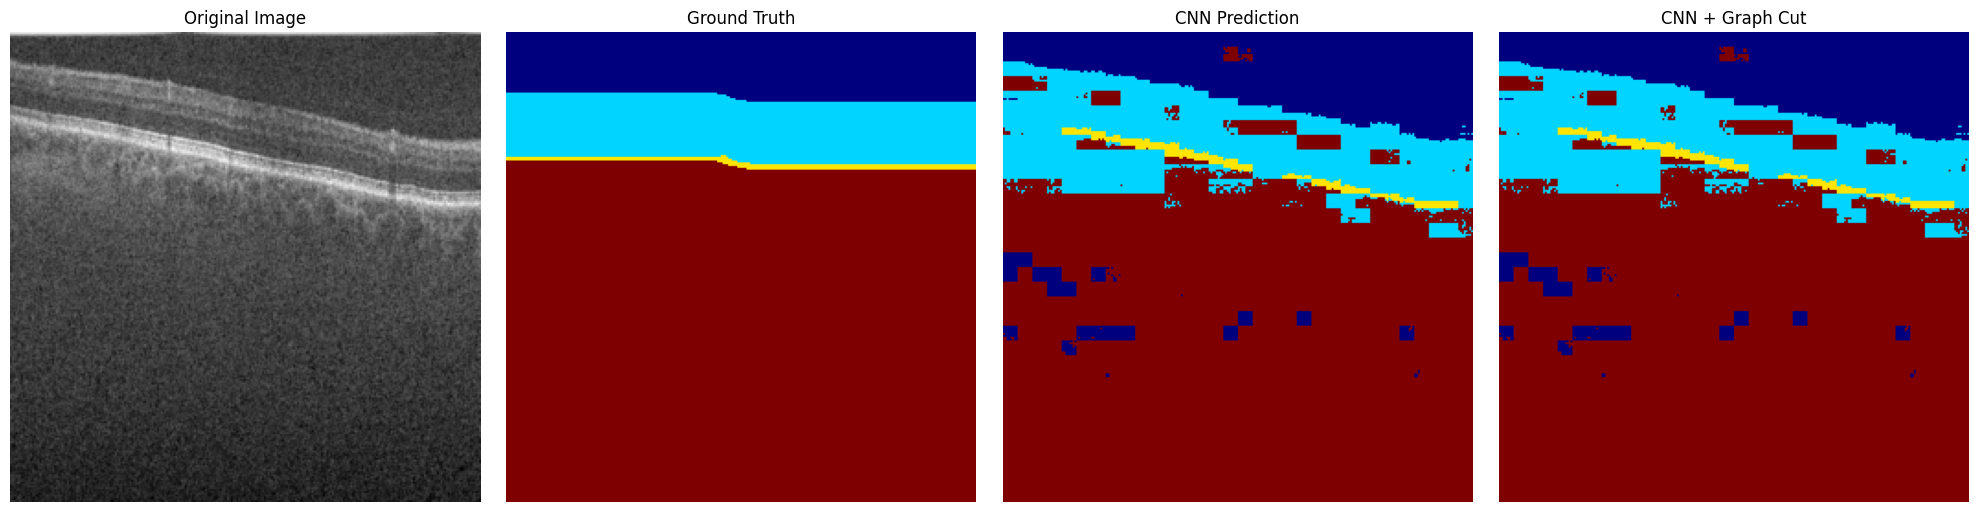

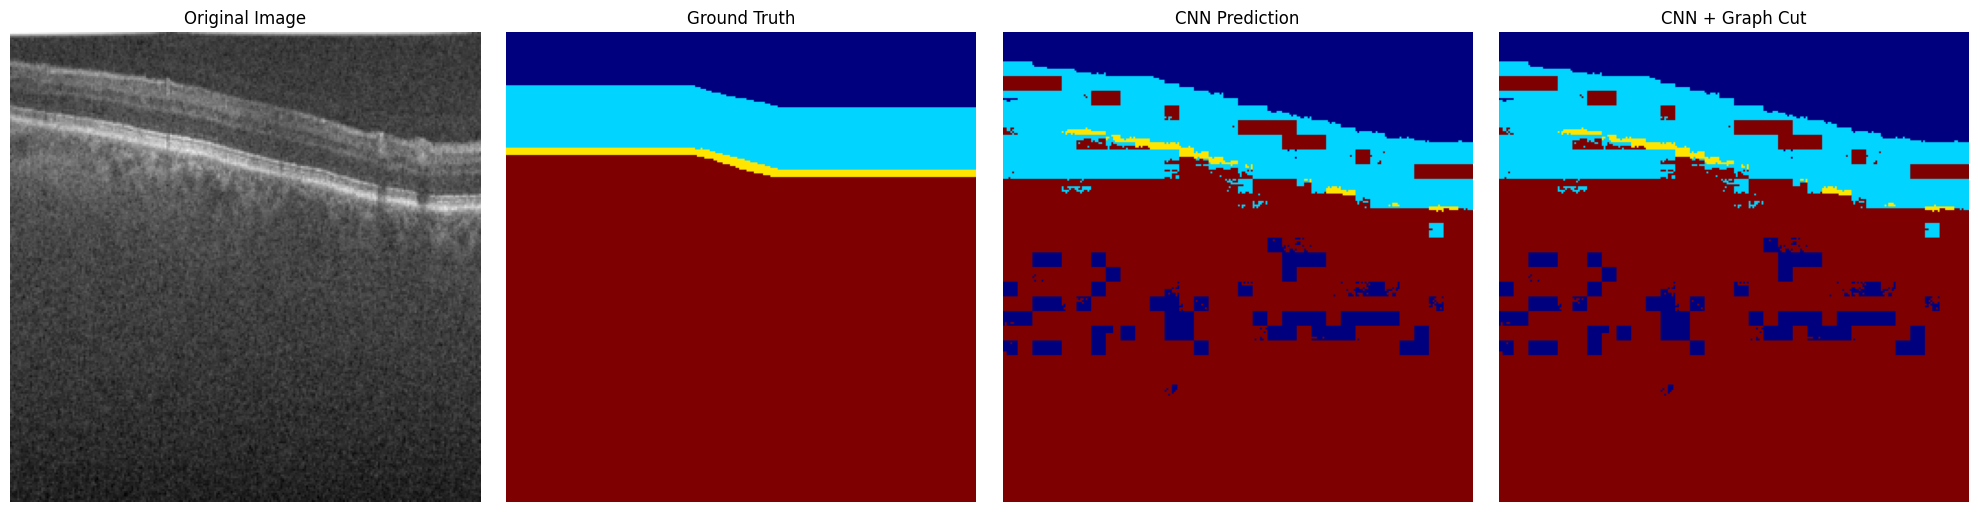

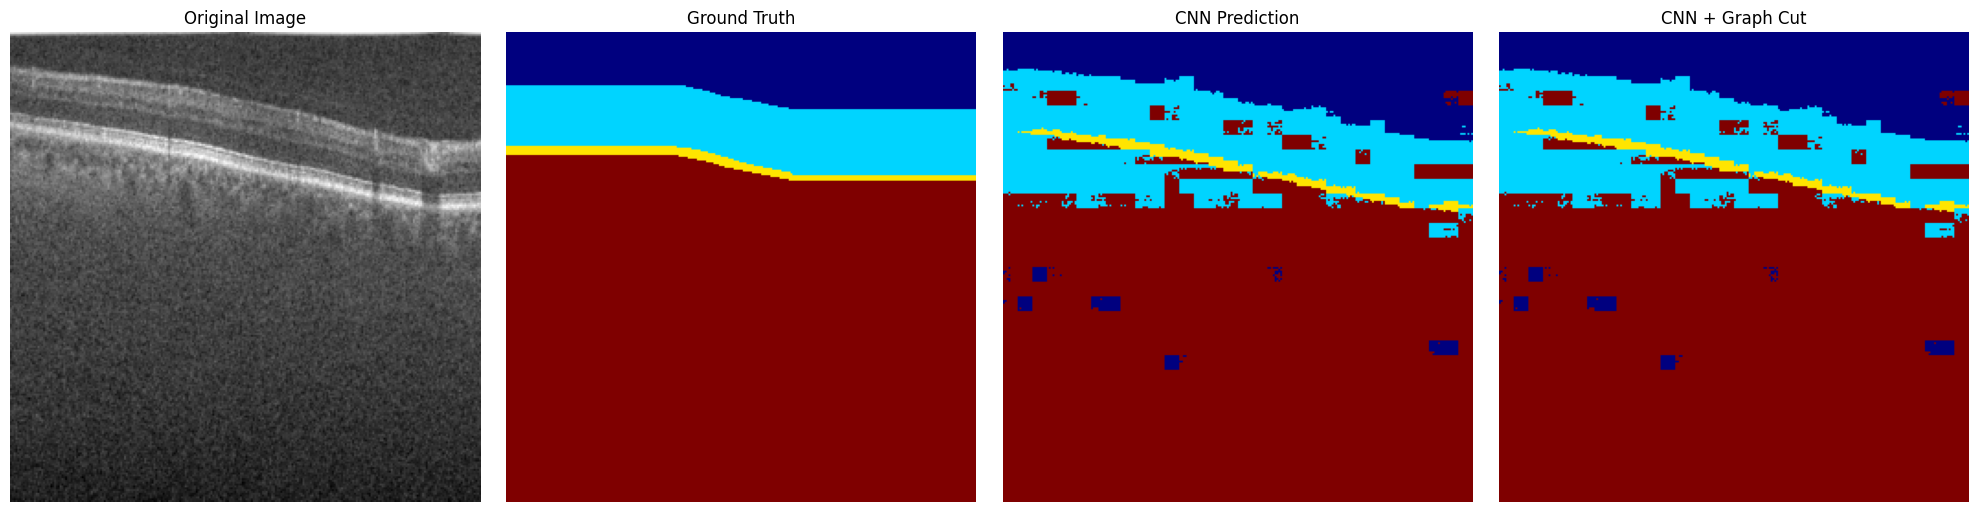

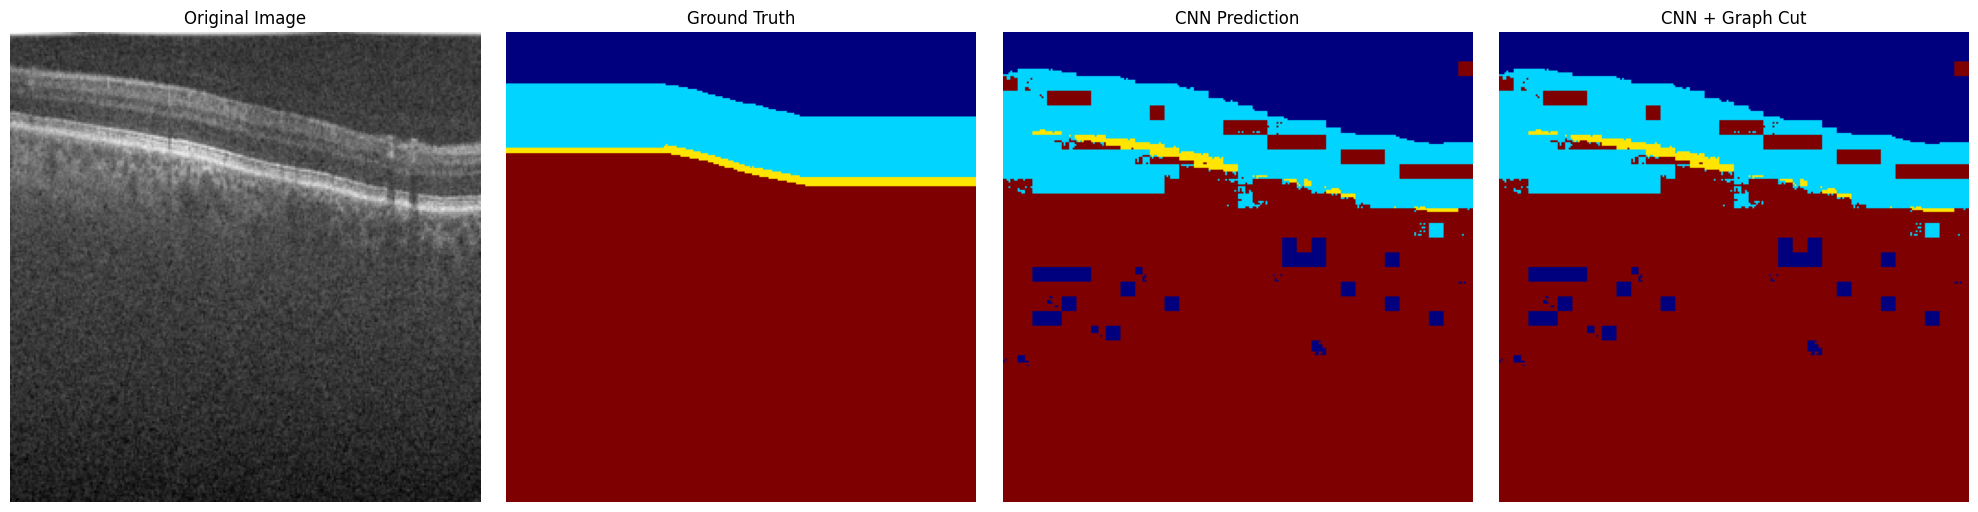

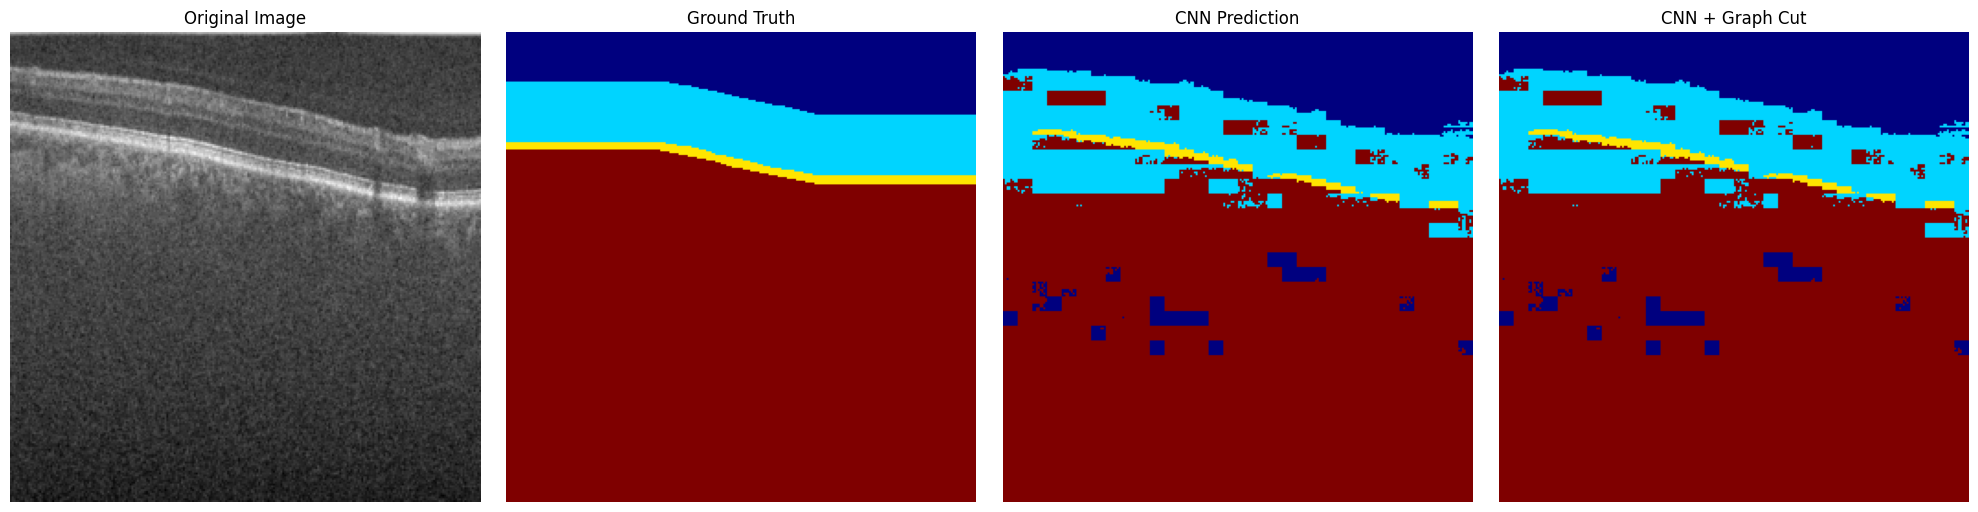

In [8]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# -------------------
# CONFIG
# -------------------
TEST_DIR = "/content/dataset_splits (normal)/test"
PRED_DIR = "/content/shallowcnn_predictions"
GC_DIR   = "/content/shallowcnn_graphcut_predictions"

NUM_IMAGES = 5  # Number of images to visualize

# Get list of image filenames
img_files = sorted([f for f in os.listdir(os.path.join(TEST_DIR, "images")) if f.endswith(".png")])[:NUM_IMAGES]

# -------------------
# VISUALIZATION
# -------------------
for img_name in img_files:
    img = np.array(Image.open(os.path.join(TEST_DIR, "images", img_name)).convert("L"))
    gt_mask = np.array(Image.open(os.path.join(TEST_DIR, "masks", img_name)).convert("L"))
    cnn_mask = np.array(Image.open(os.path.join(PRED_DIR, img_name))).astype(np.uint8)
    gc_mask = np.array(Image.open(os.path.join(GC_DIR, img_name))).astype(np.uint8)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(img, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(gt_mask, cmap="jet", vmin=0, vmax=3)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    axes[2].imshow(cnn_mask, cmap="jet", vmin=0, vmax=3)
    axes[2].set_title("CNN Prediction")
    axes[2].axis("off")

    axes[3].imshow(gc_mask, cmap="jet", vmin=0, vmax=3)
    axes[3].set_title("CNN + Graph Cut")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()

In [9]:
import os
import numpy as np
from PIL import Image

# -------------------
# CONFIG
# -------------------
TEST_DIR = "/content/dataset_splits (normal)/test"
PRED_DIR = "/content/shallowcnn_predictions"
GC_DIR   = "/content/shallowcnn_graphcut_predictions"

NUM_CLASSES = 4

# -------------------
# METRIC FUNCTIONS
# -------------------
def dice_coefficient(y_true, y_pred, num_classes=4):
    dice_per_class = []
    for c in range(num_classes):
        y_true_c = (y_true == c).astype(np.uint8)
        y_pred_c = (y_pred == c).astype(np.uint8)
        intersection = np.sum(y_true_c * y_pred_c)
        union = np.sum(y_true_c) + np.sum(y_pred_c)
        dice = (2 * intersection) / (union + 1e-8)
        dice_per_class.append(dice)
    return dice_per_class, np.mean(dice_per_class)

def iou_score(y_true, y_pred, num_classes=4):
    iou_per_class = []
    for c in range(num_classes):
        y_true_c = (y_true == c).astype(np.uint8)
        y_pred_c = (y_pred == c).astype(np.uint8)
        intersection = np.sum(y_true_c * y_pred_c)
        union = np.sum((y_true_c + y_pred_c) > 0)
        iou = intersection / (union + 1e-8)
        iou_per_class.append(iou)
    return iou_per_class, np.mean(iou_per_class)

def precision_score(y_true, y_pred, num_classes=4):
    precision_per_class = []
    for c in range(num_classes):
        y_true_c = (y_true == c).astype(np.uint8)
        y_pred_c = (y_pred == c).astype(np.uint8)
        tp = np.sum(y_true_c * y_pred_c)
        fp = np.sum((y_pred_c == 1) & (y_true_c == 0))
        precision = tp / (tp + fp + 1e-8)
        precision_per_class.append(precision)
    return precision_per_class, np.mean(precision_per_class)

def recall_score(y_true, y_pred, num_classes=4):
    recall_per_class = []
    for c in range(num_classes):
        y_true_c = (y_true == c).astype(np.uint8)
        y_pred_c = (y_pred == c).astype(np.uint8)
        tp = np.sum(y_true_c * y_pred_c)
        fn = np.sum((y_true_c == 1) & (y_pred_c == 0))
        recall = tp / (tp + fn + 1e-8)
        recall_per_class.append(recall)
    return recall_per_class, np.mean(recall_per_class)

# -------------------
# LOAD FILES
# -------------------
img_files = sorted([f for f in os.listdir(os.path.join(TEST_DIR, "images")) if f.endswith(".png")])

# Store results
dice_cnn_all, dice_gc_all = [], []
iou_cnn_all, iou_gc_all = [], []
precision_cnn_all, precision_gc_all = [], []
recall_cnn_all, recall_gc_all = [], []

for img_name in img_files:
    gt_mask = np.array(Image.open(os.path.join(TEST_DIR, "masks", img_name)).convert("L"))
    cnn_mask = np.array(Image.open(os.path.join(PRED_DIR, img_name))).astype(np.uint8)
    gc_mask  = np.array(Image.open(os.path.join(GC_DIR, img_name))).astype(np.uint8)

    # Dice
    dice_cnn, _ = dice_coefficient(gt_mask, cnn_mask, NUM_CLASSES)
    dice_gc, _  = dice_coefficient(gt_mask, gc_mask, NUM_CLASSES)
    dice_cnn_all.append(dice_cnn)
    dice_gc_all.append(dice_gc)

    # IoU
    iou_cnn, _ = iou_score(gt_mask, cnn_mask, NUM_CLASSES)
    iou_gc, _  = iou_score(gt_mask, gc_mask, NUM_CLASSES)
    iou_cnn_all.append(iou_cnn)
    iou_gc_all.append(iou_gc)

    # Precision
    precision_cnn, _ = precision_score(gt_mask, cnn_mask, NUM_CLASSES)
    precision_gc, _  = precision_score(gt_mask, gc_mask, NUM_CLASSES)
    precision_cnn_all.append(precision_cnn)
    precision_gc_all.append(precision_gc)

    # Recall
    recall_cnn, _ = recall_score(gt_mask, cnn_mask, NUM_CLASSES)
    recall_gc, _  = recall_score(gt_mask, gc_mask, NUM_CLASSES)
    recall_cnn_all.append(recall_cnn)
    recall_gc_all.append(recall_gc)

# Convert to numpy arrays for averaging
dice_cnn_all = np.array(dice_cnn_all)
dice_gc_all = np.array(dice_gc_all)
iou_cnn_all = np.array(iou_cnn_all)
iou_gc_all = np.array(iou_gc_all)
precision_cnn_all = np.array(precision_cnn_all)
precision_gc_all = np.array(precision_gc_all)
recall_cnn_all = np.array(recall_cnn_all)
recall_gc_all = np.array(recall_gc_all)

# -------------------
# PRINT RESULTS
# -------------------
for c in range(NUM_CLASSES):
    print(f"Class {c}:")
    print(f"  Dice       - CNN: {dice_cnn_all[:,c].mean():.4f}, CNN+GC: {dice_gc_all[:,c].mean():.4f}")
    print(f"  IoU        - CNN: {iou_cnn_all[:,c].mean():.4f}, CNN+GC: {iou_gc_all[:,c].mean():.4f}")
    print(f"  Precision  - CNN: {precision_cnn_all[:,c].mean():.4f}, CNN+GC: {precision_gc_all[:,c].mean():.4f}")
    print(f"  Recall     - CNN: {recall_cnn_all[:,c].mean():.4f}, CNN+GC: {recall_gc_all[:,c].mean():.4f}")

print("\nMean across all classes:")
print(f"  Dice      - CNN: {dice_cnn_all.mean():.4f}, CNN+GC: {dice_gc_all.mean():.4f}")
print(f"  IoU       - CNN: {iou_cnn_all.mean():.4f}, CNN+GC: {iou_gc_all.mean():.4f}")
print(f"  Precision - CNN: {precision_cnn_all.mean():.4f}, CNN+GC: {precision_gc_all.mean():.4f}")
print(f"  Recall    - CNN: {recall_cnn_all.mean():.4f}, CNN+GC: {recall_gc_all.mean():.4f}")

Class 0:
  Dice       - CNN: 0.8564, CNN+GC: 0.8564
  IoU        - CNN: 0.7609, CNN+GC: 0.7609
  Precision  - CNN: 0.8628, CNN+GC: 0.8628
  Recall     - CNN: 0.8789, CNN+GC: 0.8789
Class 1:
  Dice       - CNN: 0.7399, CNN+GC: 0.7399
  IoU        - CNN: 0.6008, CNN+GC: 0.6008
  Precision  - CNN: 0.7113, CNN+GC: 0.7113
  Recall     - CNN: 0.8004, CNN+GC: 0.8004
Class 2:
  Dice       - CNN: 0.4874, CNN+GC: 0.4874
  IoU        - CNN: 0.3425, CNN+GC: 0.3425
  Precision  - CNN: 0.5952, CNN+GC: 0.5952
  Recall     - CNN: 0.4510, CNN+GC: 0.4510
Class 3:
  Dice       - CNN: 0.9180, CNN+GC: 0.9180
  IoU        - CNN: 0.8500, CNN+GC: 0.8500
  Precision  - CNN: 0.9357, CNN+GC: 0.9357
  Recall     - CNN: 0.9043, CNN+GC: 0.9043

Mean across all classes:
  Dice      - CNN: 0.7505, CNN+GC: 0.7505
  IoU       - CNN: 0.6385, CNN+GC: 0.6385
  Precision - CNN: 0.7763, CNN+GC: 0.7763
  Recall    - CNN: 0.7586, CNN+GC: 0.7586
